In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import pickle
import adniEnsemble as adens

In [2]:
adnifulldf = pd.read_csv("../Dataset/ADNI/adnitable.csv")

In [3]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [4]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [5]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [6]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


## MRI

In [43]:
## prepare data with appropriate features and randomization
shuffled_df = mridf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age','APOE'], mri_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
# mlmodel = SVC(C=1e0, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
sensitivity_test, specificity_test = adens.SensiSpeci(testing_Y, mlmodel.predict(testing_X))
# test model - training data
sensitivity_train, specificity_train = adens.SensiSpeci(training_Y, mlmodel.predict(training_X))

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 82.65, Specificity: 92.08
Train: Sensitivity = 86.00, Specificity: 94.82


In [41]:
shuffled_df.mean()

RID        2.125878e+03
Gender     1.465367e+00
Educ       1.592942e+01
Age        7.583987e+01
APOE       8.691072e-02
MMSE       2.593732e+01
mri_001    9.150603e+02
mri_002    4.616630e+03
mri_003    1.782478e+03
mri_004    2.463596e+00
mri_005    1.513138e+03
mri_006    1.390555e+03
mri_007    4.939721e+02
mri_008    1.684568e+03
mri_009    1.501626e+03
mri_010    3.123487e+02
mri_011    1.090576e+03
mri_012    3.016261e+03
mri_013    1.093178e+03
mri_014    1.651651e+03
mri_015    2.367179e+03
mri_016    2.365196e+04
mri_017    7.369565e+03
mri_018    1.739098e+03
mri_019    1.226668e+03
mri_020    4.439368e+03
mri_021    1.964076e+03
mri_022    8.302933e+02
mri_023    1.636909e+03
mri_024    5.697299e+02
               ...     
mri_104    2.937956e+03
mri_105    2.424609e+00
mri_106    1.440391e+04
mri_107    4.635217e+03
mri_108    1.453106e+03
mri_109    1.011248e+03
mri_110    2.248129e+03
mri_111    8.199811e+02
mri_112    3.077109e+03
mri_113    2.187932e+03
mri_114    6.808

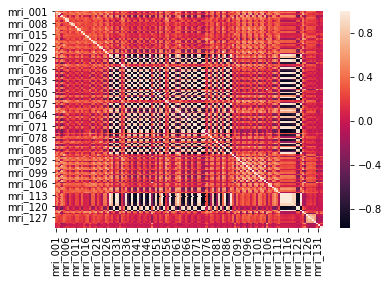

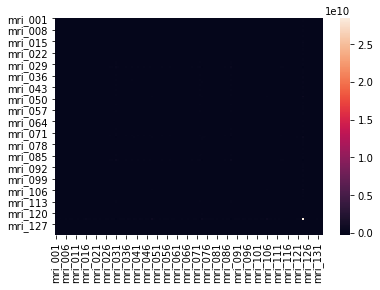

In [50]:
sns.heatmap(shuffled_df[features].cov())
plt.show()
sns.heatmap(mridf[features].cov())
plt.show()

In [ ]:
amyloiddf['DX_bin'] = np.where(amyloiddf["DX"]=="CN", 0, 1)
grid_out = adens.ttSplitWithGridSearch('svm', svc_param_grid, 4, 
                                              amyloiddf, features, 'DX_bin', 0.8, 0) 

In [69]:
import tensorflow as tf
from tensorflow import keras

shuffled_df = mridf.sample(frac=1, random_state=1)
# features = [item for sublist in [['Gender','Educ','Age','APOE'], mri_vars] for item in sublist]
features = mri_vars
shuffled_df[features] = (shuffled_df[features]-shuffled_df[features].mean())/(shuffled_df[features].std())
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.7
validation_frac = 0.1
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))
num_samples_vald = int(np.round(num_samples*validation_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
validation_X = data_X[num_samples_train:(num_samples_train+num_samples_vald),:]
validation_Y = data_Y[num_samples_train:(num_samples_train+num_samples_vald)]
testing_X = data_X[(num_samples_train+num_samples_vald):,:]
testing_Y = data_Y[(num_samples_train+num_samples_vald):]


In [80]:
# specify the model
dlmodel = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dlmodel.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

dlmodel_history = dlmodel.fit(training_X, training_Y, epochs=40, validation_data=(validation_X, validation_Y))

Train on 2658 samples, validate on 380 samples
Epoch 1/40
2658/2658 [==============================] - 0s 164us/step - loss: 0.4243 - acc: 0.8111 - val_loss: 0.3199 - val_acc: 0.8632
Epoch 2/40
2658/2658 [==============================] - 0s 48us/step - loss: 0.2894 - acc: 0.8883 - val_loss: 0.2760 - val_acc: 0.8842
Epoch 3/40
2658/2658 [==============================] - 0s 48us/step - loss: 0.2495 - acc: 0.9116 - val_loss: 0.2590 - val_acc: 0.8921
Epoch 4/40
2658/2658 [==============================] - 0s 55us/step - loss: 0.2332 - acc: 0.9120 - val_loss: 0.2446 - val_acc: 0.9026
Epoch 5/40
2658/2658 [==============================] - 0s 51us/step - loss: 0.2120 - acc: 0.9281 - val_loss: 0.2169 - val_acc: 0.9105
Epoch 6/40
2658/2658 [==============================] - 0s 58us/step - loss: 0.1961 - acc: 0.9327 - val_loss: 0.2233 - val_acc: 0.9132
Epoch 7/40
2658/2658 [==============================] - 0s 55us/step - loss: 0.1836 - acc: 0.9375 - val_loss: 0.2109 - val_acc: 0.9237
Epoch 8

In [78]:
dlmodel.weights

TypeError: 'list' object is not callable

In [62]:
dlmodel.evaluate(testing_X, testing_Y)

759/759 [==============================] - 0s 92us/step


[0.10467036443422592, 0.9683794469544382]

In [81]:
[gridout['test_score']['accuracy'] for gridout in pickle.load(open('../Dataset/ProcessedFiles/mri_svm_cv.pckl','rb'))]

[94.82758620689656,
 93.89920424403184,
 94.29708222811671,
 94.29708222811671,
 94.9602122015915,
 95.09283819628646,
 93.89920424403184,
 93.89920424403184,
 94.56233421750663,
 94.6949602122016]

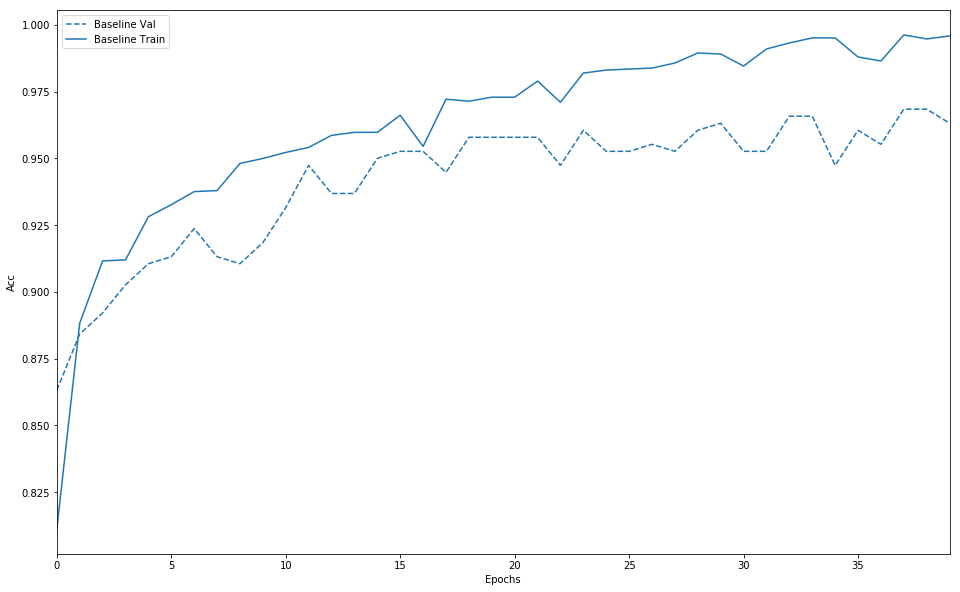

In [91]:
def plot_history(histories, key):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history(histories=[('baseline', dlmodel.history)], key='acc')

In [92]:
amyloiddf['DX_bin'] = np.where(amyloiddf["DX"]=="CN", 0, 1)
features = [item for sublist in [['Gender','Age','Educ','APOE'], amyloid_vars] for item in sublist]

In [94]:
train_X, test_X, train_Y, test_Y = train_test_split(
    amyloiddf[features], amyloiddf['DX_bin'], train_size=0.8, test_size=0.2,
    random_state=0, shuffle=True)

In [102]:
mean_list = np.mean(train_X, axis=0)
std_list = np.std(train_X, axis=0)

print(np.std((test_X-mean_list)/std_list))
print(std_list)

Gender        1.000044
Age           0.947217
Educ          0.969644
APOE          1.250293
amyloid_01    0.947716
amyloid_02    0.900736
amyloid_03    0.972888
amyloid_04    0.986007
amyloid_05    1.079427
amyloid_06    1.004542
dtype: float64
Gender        0.499898
Age           7.204899
Educ          2.659972
APOE          0.247146
amyloid_01    0.314005
amyloid_02    0.324637
amyloid_03    0.312845
amyloid_04    0.276639
amyloid_05    0.148476
amyloid_06    0.497561
dtype: float64
